In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def generate_trials(n_trials=100, rel_mu=25, rel_sigma=2, comp_mu=8, comp_sigma=1):
    comps = [0.33, 0.8]
    trials = []

    # 초기 competency와 reliability 설정
    left_comp, right_comp = np.random.choice(comps, 2, replace=False)
    left_rel = 0.25
    right_rel = 0.10

    # 초기 reliability swap 여부 결정
    if np.random.rand() < 0.5:
        left_rel, right_rel = right_rel, left_rel
        initial_rel_swap = True
    else:
        initial_rel_swap = False

    comp_change_points = [0]
    rel_change_points = []

    # 초기 다음 변화 시점 설정
    next_rel_swap = int(np.clip(np.random.normal(rel_mu, rel_sigma), 5, n_trials - 1))
    next_comp_swap = int(np.clip(np.random.normal(comp_mu, comp_sigma), 3, n_trials - 1))

    t = 0
    while t < n_trials:
        # competency 갱신
        if t == next_comp_swap:
            # 서로 다른 competency 2개 뽑기
            left_comp, right_comp = np.random.choice(comps, 2, replace=False)
            comp_change_points.append(t)

            # 다음 swap 시점 설정
            offset = int(np.clip(np.random.normal(comp_mu, comp_sigma), 3, n_trials - t - 1))
            next_comp_swap = t + offset

        # reliability swap 시점 도달 시 swap
        if t == next_rel_swap:
            left_rel, right_rel = right_rel, left_rel
            rel_change_points.append(t)

            offset = int(np.clip(np.random.normal(rel_mu, rel_sigma), 5, n_trials - t - 1))
            next_rel_swap = t + offset

        trials.append({
            'left_competency': left_comp,
            'right_competency': right_comp,
            'left_reliability': left_rel,
            'right_reliability': right_rel
        })

        t += 1

    return pd.DataFrame(trials), comp_change_points, rel_change_points


# 테스트 실행
trialinfo, comp_changes, rel_changes = generate_trials()

# print(trialinfo)
# print("Competency change points:", comp_changes)
# print("Reliability change points:", rel_changes)

# ENV 로그 스페이스로 새 단장 중

### 기존

In [ ]:
# 통합된 EelEnv 클래스 정의: competency + reliability + side posterior 추정 포함

import numpy as np
from scipy.stats import norm

def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

def normal_int_prob(n, mu, sigma):
    lower = n - 0.5
    upper = n + 0.5
    return norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma)

class EelEnv:
    def __init__(self, trials, get_state_fn=None):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.trial_log = []
        self.posterior_log = []  # For side (competency or general)
        self.posterior_log_comp = []  # For competency
        self.posterior_log_rel = []  # For reliability
        self.get_state_fn = get_state_fn if get_state_fn else self.default_get_state

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.trial_log = []
        self.posterior_log = []
        self.posterior_log_comp = []
        self.posterior_log_rel = []
        return self.get_state()

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 1.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward, n_fish))
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        return self.get_state_fn(self)

    def default_get_state(self, _=None):
        return np.array([0.0, 0.0, 0.0, 0.0])

    # 라플라스 smoothing 적용
    def compute_prior_from_log(self, log_list, window=7):
        recent = log_list[-window:]
        count_h1 = recent.count("H1")
        count_h2 = recent.count("H2")

        # Laplace smoothing (+1 to numerator, +2 to denominator)
        prior_h1 = (count_h1 + 1) / (count_h1 + count_h2 + 2)
        prior_h2 = (count_h2 + 1) / (count_h1 + count_h2 + 2)

        return prior_h1, prior_h2


    def compute_side_posteriors(self, memory_window=7, high=0.8, low=0.33):
        recent = self.trial_log[-memory_window:]
        lh_h1 = lh_h2 = 1.0
        for action, _, n_fish in recent:
            mu_L_h1 = high * 3
            mu_R_h1 = low * 3
            mu_L_h2 = low * 3
            mu_R_h2 = high * 3
            if action == 0:
                lh_h1 *= normal_int_prob(n_fish, mu_L_h1, 0.5)
                lh_h2 *= normal_int_prob(n_fish, mu_L_h2, 0.5)
            else:
                lh_h1 *= normal_int_prob(n_fish, mu_R_h1, 0.5)
                lh_h2 *= normal_int_prob(n_fish, mu_R_h2, 0.5)
        prior_h1, prior_h2 = self.compute_prior_from_log(self.posterior_log, window=7)
        posterior_h1 = lh_h1 * prior_h1
        posterior_h2 = lh_h2 * prior_h2
        total = posterior_h1 + posterior_h2
        if total == 0:
            return 0.5, 0.5
        print(f"[DEBUG] rel posterior → lh_h1: {lh_h1:.4f}, lh_h2: {lh_h2:.4f}, prior_h1: {prior_h1:.2f}, prior_h2: {prior_h2:.2f}")
        print(f"[DEBUG] → posterior_h1: {posterior_h1:.4f}, posterior_h2: {posterior_h2:.4f}")
        return posterior_h1 / total, posterior_h2 / total

    def compute_competency_posteriors(self, memory_window=7, high=0.8, low=0.33):
        return self.compute_side_posteriors(memory_window=memory_window, high=high, low=low)

    def compute_reliability_posteriors(self, memory_window=7, high=0.25, low=0.10):
        recent = self.trial_log[-memory_window:]
        lh_h1 = lh_h2 = 1.0
        for action, reward, n_fish in recent:
            rel_L_h1 = high
            rel_R_h1 = low
            rel_L_h2 = low
            rel_R_h2 = high
            rel_h1 = rel_L_h1 if action == 0 else rel_R_h1
            rel_h2 = rel_L_h2 if action == 0 else rel_R_h2
            p_r_h1 = min(1.0, rel_h1 * n_fish)
            p_r_h2 = min(1.0, rel_h2 * n_fish)
            lh_h1 *= p_r_h1 if reward else (1 - p_r_h1)
            lh_h2 *= p_r_h2 if reward else (1 - p_r_h2)
        prior_h1, prior_h2 = self.compute_prior_from_log(self.posterior_log_rel, window=7)
        posterior_h1 = lh_h1 * prior_h1
        posterior_h2 = lh_h2 * prior_h2
        total = posterior_h1 + posterior_h2
        if total == 0:
            return 0.5, 0.5
        # print(f"[DEBUG] trial {self.current_trial} → reward: {reward}, n_fish: {n_fish}, action: {action}")
        # print(f"[DEBUG] rel posterior → lh_h1: {lh_h1:.4f}, lh_h2: {lh_h2:.4f}, prior_h1: {prior_h1:.2f}, prior_h2: {prior_h2:.2f}")
        # print(f"[DEBUG] → posterior_h1: {posterior_h1:.4f}, posterior_h2: {posterior_h2:.4f}")

        return posterior_h1 / total, posterior_h2 / total

Q1d = np.zeros((11, 2))         # 상태 1개 (quantized p_h1), 액션 2개
Q2d = np.zeros((11, 11, 2))     # 상태 2개 (p_h1, p_h2), 액션 2개
Q4d = np.zeros((11, 11, 11, 11, 2))


### ENV 베이지안 수정 중

In [21]:
# 통합된 EelEnv 클래스 정의: competency + reliability + side posterior 추정 포함

import numpy as np
from scipy.stats import norm
import math  # 꼭 필요

def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

def normal_int_prob(n, mu, sigma):
    lower = n - 0.5
    upper = n + 0.5
    return norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma)

class EelEnv:
    def __init__(self, trials, get_state_fn=None):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.trial_log = []
        self.posterior_log = []  # For side (competency or general)
        self.posterior_log_comp = []  # For competency
        self.posterior_log_rel = []  # For reliability
        self.get_state_fn = get_state_fn if get_state_fn else self.default_get_state

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.trial_log = []
        self.posterior_log = []
        self.posterior_log_comp = []
        self.posterior_log_rel = []
        return self.get_state()

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 1.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward, n_fish))
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        return self.get_state_fn(self)

    def default_get_state(self, _=None):
        return np.array([0.0, 0.0, 0.0, 0.0])

    # 라플라스 smoothing 적용
    def compute_prior_from_log(self, log_list, window=7):
        recent = log_list[-window:]
        count_h1 = recent.count("H1")
        count_h2 = recent.count("H2")

        # Laplace smoothing (+1 to numerator, +2 to denominator)
        prior_h1 = (count_h1 + 1) / (count_h1 + count_h2 + 2)
        prior_h2 = (count_h2 + 1) / (count_h1 + count_h2 + 2)

        return prior_h1, prior_h2



    def compute_side_posteriors(self, memory_window=5, high=0.8, low=0.33):
        recent = self.trial_log[-memory_window:]
        log_lh_h1 = log_lh_h2 = 0.0
        for action, _, n_fish in recent:
            mu_L_h1 = high * 3
            mu_R_h1 = low * 3
            mu_L_h2 = low * 3
            mu_R_h2 = high * 3
            if action == 0:
                p1 = max(normal_int_prob(n_fish, mu_L_h1, 0.5), 1e-8)
                p2 = max(normal_int_prob(n_fish, mu_L_h2, 0.5), 1e-8)
            else:
                p1 = max(normal_int_prob(n_fish, mu_R_h1, 0.5), 1e-8)
                p2 = max(normal_int_prob(n_fish, mu_R_h2, 0.5), 1e-8)
            log_lh_h1 += math.log(p1)
            log_lh_h2 += math.log(p2)

        prior_h1, prior_h2 = self.compute_prior_from_log(self.posterior_log, window=7)
        log_post_h1 = log_lh_h1 + math.log(prior_h1 + 1e-8)
        log_post_h2 = log_lh_h2 + math.log(prior_h2 + 1e-8)

        max_log = max(log_post_h1, log_post_h2)
        post_h1 = math.exp(log_post_h1 - max_log)
        post_h2 = math.exp(log_post_h2 - max_log)
        total = post_h1 + post_h2

        # print(f"[DEBUG] rel posterior → lh_h1: {log_lh_h1:.4f}, lh_h2: {log_lh_h2:.4f}, prior_h1: {prior_h1:.2f}, prior_h2: {prior_h2:.2f}")
        # print(f"[DEBUG] → posterior_h1: {post_h1:.4f}, posterior_h2: {post_h2:.4f}")
        return post_h1 / total, post_h2 / total

    def compute_competency_posteriors(self, memory_window=5, high=0.8, low=0.33):
        return self.compute_side_posteriors(memory_window=memory_window, high=high, low=low)


    def compute_reliability_posteriors(self, memory_window=5, high=0.25, low=0.10):
        recent = self.trial_log[-memory_window:]
        log_lh_h1 = 0.0
        log_lh_h2 = 0.0

        for action, reward, n_fish in recent:
            if action == 0:  # 왼쪽 선택 → H1의 정보를 관측한 것
                rel_h1 = high  # H1: 왼쪽이 high
                rel_h2 = low   # H2: 왼쪽이 low
                p1 = min(1.0, rel_h1 * n_fish)
                p2 = min(1.0, rel_h2 * n_fish)
                log_lh_h1 += math.log(max(p1 if reward else (1 - p1), 1e-8))
                log_lh_h2 += math.log(max(p2 if reward else (1 - p2), 1e-8))

            elif action == 1:  # 오른쪽 선택 → H2의 정보를 관측한 것
                rel_h1 = low   # H1: 오른쪽이 low
                rel_h2 = high  # H2: 오른쪽이 high
                p1 = min(1.0, rel_h1 * n_fish)
                p2 = min(1.0, rel_h2 * n_fish)
                log_lh_h1 += math.log(max(p1 if reward else (1 - p1), 1e-8))
                log_lh_h2 += math.log(max(p2 if reward else (1 - p2), 1e-8))

        # prior 불러오기
        prior_h1, prior_h2 = self.compute_prior_from_log(self.posterior_log_rel, window=7)

        # posterior 계산 (log-space)
        log_post_h1 = log_lh_h1 + math.log(prior_h1 + 1e-8)
        log_post_h2 = log_lh_h2 + math.log(prior_h2 + 1e-8)

        # normalize with log-sum-exp trick
        max_log = max(log_post_h1, log_post_h2)
        post_h1 = math.exp(log_post_h1 - max_log)
        post_h2 = math.exp(log_post_h2 - max_log)
        total = post_h1 + post_h2

        return post_h1 / total, post_h2 / total



Q1d = np.zeros((11, 2))         # 상태 1개 (quantized p_h1), 액션 2개
Q2d = np.zeros((11, 11, 2))     # 상태 2개 (p_h1, p_h2), 액션 2개
Q4d = np.zeros((11, 11, 11, 11, 2))


### 로그

In [19]:
# 통합된 EelEnv 클래스 정의: competency + reliability + side posterior 추정 포함

import numpy as np
from scipy.stats import norm
import math  # 꼭 필요

def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

def normal_int_prob(n, mu, sigma):
    lower = n - 0.5
    upper = n + 0.5
    return norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma)

class EelEnv:
    def __init__(self, trials, get_state_fn=None):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.trial_log = []
        self.posterior_log = []  # For side (competency or general)
        self.posterior_log_comp = []  # For competency
        self.posterior_log_rel = []  # For reliability
        self.get_state_fn = get_state_fn if get_state_fn else self.default_get_state

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.trial_log = []
        self.posterior_log = []
        self.posterior_log_comp = []
        self.posterior_log_rel = []
        return self.get_state()

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 1.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward, n_fish))
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        return self.get_state_fn(self)

    def default_get_state(self, _=None):
        return np.array([0.0, 0.0, 0.0, 0.0])

    # 라플라스 smoothing 적용
    def compute_prior_from_log(self, log_list, window=7):
        recent = log_list[-window:]
        count_h1 = recent.count("H1")
        count_h2 = recent.count("H2")

        # Laplace smoothing (+1 to numerator, +2 to denominator)
        prior_h1 = (count_h1 + 1) / (count_h1 + count_h2 + 2)
        prior_h2 = (count_h2 + 1) / (count_h1 + count_h2 + 2)

        return prior_h1, prior_h2



    def compute_side_posteriors(self, memory_window=7, high=0.8, low=0.33):
        recent = self.trial_log[-memory_window:]
        log_lh_h1 = log_lh_h2 = 0.0
        for action, _, n_fish in recent:
            mu_L_h1 = high * 3
            mu_R_h1 = low * 3
            mu_L_h2 = low * 3
            mu_R_h2 = high * 3
            if action == 0:
                p1 = max(normal_int_prob(n_fish, mu_L_h1, 0.5), 1e-8)
                p2 = max(normal_int_prob(n_fish, mu_L_h2, 0.5), 1e-8)
            else:
                p1 = max(normal_int_prob(n_fish, mu_R_h1, 0.5), 1e-8)
                p2 = max(normal_int_prob(n_fish, mu_R_h2, 0.5), 1e-8)
            log_lh_h1 += math.log(p1)
            log_lh_h2 += math.log(p2)

        prior_h1, prior_h2 = self.compute_prior_from_log(self.posterior_log, window=7)
        log_post_h1 = log_lh_h1 + math.log(prior_h1 + 1e-8)
        log_post_h2 = log_lh_h2 + math.log(prior_h2 + 1e-8)

        max_log = max(log_post_h1, log_post_h2)
        post_h1 = math.exp(log_post_h1 - max_log)
        post_h2 = math.exp(log_post_h2 - max_log)
        total = post_h1 + post_h2

        # print(f"[DEBUG] rel posterior → lh_h1: {log_lh_h1:.4f}, lh_h2: {log_lh_h2:.4f}, prior_h1: {prior_h1:.2f}, prior_h2: {prior_h2:.2f}")
        # print(f"[DEBUG] → posterior_h1: {post_h1:.4f}, posterior_h2: {post_h2:.4f}")
        return post_h1 / total, post_h2 / total

    def compute_competency_posteriors(self, memory_window=7, high=0.8, low=0.33):
        return self.compute_side_posteriors(memory_window=memory_window, high=high, low=low)

    def compute_reliability_posteriors(self, memory_window=7, high=0.25, low=0.10):
        recent = self.trial_log[-memory_window:]
        log_lh_h1 = log_lh_h2 = 0.0
        for action, reward, n_fish in recent:
            rel_L_h1, rel_R_h1 = high, low
            rel_L_h2, rel_R_h2 = low, high
            rel_h1 = rel_L_h1 if action == 0 else rel_R_h1
            rel_h2 = rel_L_h2 if action == 0 else rel_R_h2
            p1 = min(1.0, rel_h1 * n_fish)
            p2 = min(1.0, rel_h2 * n_fish)
            p1 = max(p1 if reward else (1 - p1), 1e-8)
            p2 = max(p2 if reward else (1 - p2), 1e-8)
            log_lh_h1 += math.log(p1)
            log_lh_h2 += math.log(p2)

        prior_h1, prior_h2 = self.compute_prior_from_log(self.posterior_log_rel, window=7)
        log_post_h1 = log_lh_h1 + math.log(prior_h1 + 1e-8)
        log_post_h2 = log_lh_h2 + math.log(prior_h2 + 1e-8)

        max_log = max(log_post_h1, log_post_h2)
        post_h1 = math.exp(log_post_h1 - max_log)
        post_h2 = math.exp(log_post_h2 - max_log)
        total = post_h1 + post_h2
        # print(f"[DEBUG] rel posterior → lh_h1: {log_lh_h1:.4f}, lh_h2: {log_lh_h2:.4f}, prior_h1: {prior_h1:.2f}, prior_h2: {prior_h2:.2f}")
        # print(f"[DEBUG] → posterior_h1: {post_h1:.4f}, posterior_h2: {post_h2:.4f}")
        return post_h1 / total, post_h2 / total


Q1d = np.zeros((11, 2))         # 상태 1개 (quantized p_h1), 액션 2개
Q2d = np.zeros((11, 11, 2))     # 상태 2개 (p_h1, p_h2), 액션 2개
Q4d = np.zeros((11, 11, 11, 11, 2))


In [24]:
# train agent
def train_agent(get_state_fn, Q, n_episodes=300, epsilon=0.2, alpha=0.1, gamma=0.95):
    n_actions = Q.shape[-1]
    avg_rewards = []
    episode_plots = {}

    for ep in range(n_episodes):
        if (ep%50 == 0):
          print(f"Training Episode {ep}")
        df, comp_changes, rel_changes = generate_trials(300)
        env = EelEnv(df)
        env.comp_change_points = comp_changes
        env.rel_change_points = rel_changes

        env.posterior_log = []
        state = get_state_fn(env)  # state는 반드시 tuple로 반환되어야 함
        done = False
        ep_reward = 0

        actions = []
        rewards = []
        comp_changes = []
        rel_changes = []
        trial_data = []

        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(Q[state])  # 튜플 index

            next_state_raw, reward, done, info = env.step(action)
            next_state = get_state_fn(env)
            if not done:
                next_action = np.argmax(Q[next_state])
                target = reward + gamma * Q[next_state + (next_action,)]
            else:
                target = reward

            Q[state + (action,)] += alpha * (target - Q[state + (action,)])

            # 기록
            state = next_state
            ep_reward += reward
            actions.append(action)
            rewards.append(reward)
            trial_data.append(env.trials.iloc[env.current_trial - 1])
            if env.current_trial - 1 in env.comp_change_points:
                comp_changes.append(env.current_trial - 1)
            if env.current_trial - 1 in env.rel_change_points:
                rel_changes.append(env.current_trial - 1)

        avg_rewards.append(ep_reward)
        df = pd.DataFrame(trial_data)

        if (ep%50 == 0):
          episode_plots[ep] = (df, comp_changes, rel_changes, actions, rewards)

    return Q, avg_rewards, episode_plots


In [14]:
# -------- Visualization --------
def visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep_num):
    plt.figure(figsize=(12, 5))
    plt.plot(rewards, label='Reward', color='gray', alpha=0.5)

    rel_opt_list = []
    comp_opt_list = []

    for t, a in enumerate(actions):
        row = df.iloc[t]
        left_comp, right_comp = row['left_competency'], row['right_competency']
        left_rel, right_rel = row['left_reliability'], row['right_reliability']

        opt_comp = 0 if left_comp > right_comp else 1
        opt_rel = 0 if left_rel > right_rel else 1
        rel_opt_list.append(opt_rel)
        comp_opt_list.append(opt_comp)

        plt.plot(t, 1.1, 'b_' if a == 0 else 'r_', linewidth=3)
        plt.plot(t, 1.2, 'b_' if opt_comp == 0 else 'r_', linewidth=3)
        plt.plot(t, 1.3, 'b_' if opt_rel == 0 else 'r_', linewidth=3)

    for x in comp_changes:
        plt.axvline(x + 0.5, color='gold', linestyle='--', label='Comp Change' if x == comp_changes[0] else "")
    for x in rel_changes:
        plt.axvline(x + 0.5, color='purple', linestyle='--', label='Rel Change' if x == rel_changes[0] else "")

    plt.title(f"Episode {ep_num}: Reward + Action vs Competency/Rel Optimal")
    plt.xlabel("Trial")
    plt.ylim(-0.1, 1.5)
    plt.yticks([1.1, 1.2, 1.3], ['Action', 'Comp Optimal', 'Rel Optimal'])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔍 추가: Action과 Reliability Optimal 일치 비율 계산
    total = len(actions)
    correct = sum([a == ro for a, ro in zip(actions, rel_opt_list)])
    ratio = correct / total if total > 0 else 0
    print(f"[Episode {ep_num}] Action matches Rel Optimal: {correct}/{total} = {ratio:.2%}")

    # 🔍 추가: Action과 Competency Optimal 일치 비율 계산
    correct = sum([a == ro for a, ro in zip(actions, comp_opt_list)])
    ratio = correct / total if total > 0 else 0
    print(f"[Episode {ep_num}] Action matches Comp Optimal: {correct}/{total} = {ratio:.2%}")


In [15]:
def joint_bayesian_state_4d(env):
    p_h1_comp, p_h2_comp = env.compute_competency_posteriors()
    p_h1_rel, p_h2_rel = env.compute_reliability_posteriors()

    env.posterior_log_comp.append("H1" if p_h1_comp > p_h2_comp else "H2")
    env.posterior_log.append("H1" if p_h1_comp > p_h2_comp else "H2")
    env.posterior_log_rel.append("H1" if p_h1_rel > p_h2_rel else "H2")

    return (
        quantize(p_h1_comp),
        quantize(p_h2_comp),
        quantize(p_h1_rel),
        quantize(p_h2_rel)
    )

Training Episode 0
Training Episode 50
Training Episode 100
Training Episode 150
Training Episode 200
Training Episode 250


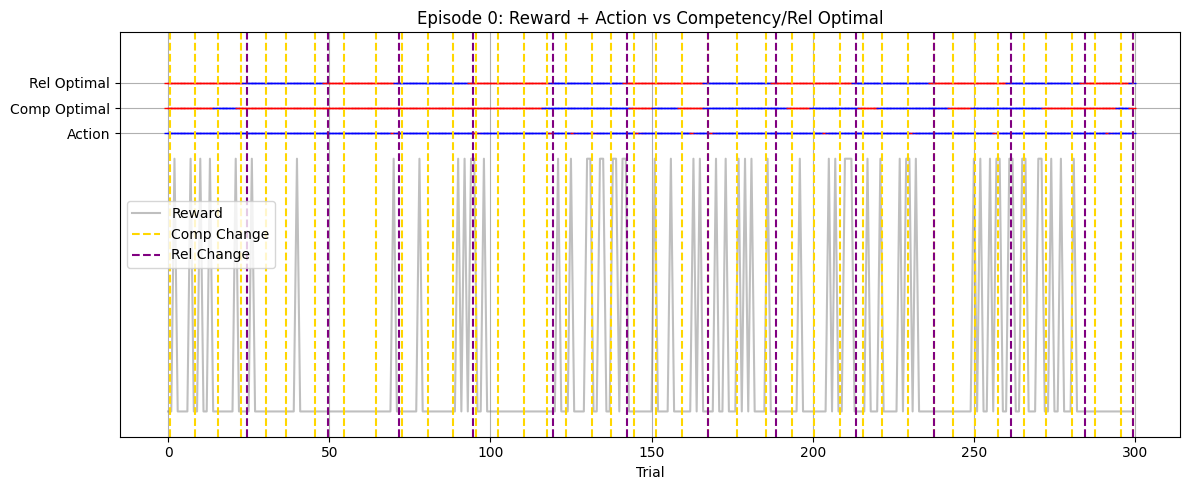

[Episode 0] Action matches Rel Optimal: 142/300 = 47.33%
[Episode 0] Action matches Comp Optimal: 129/300 = 43.00%


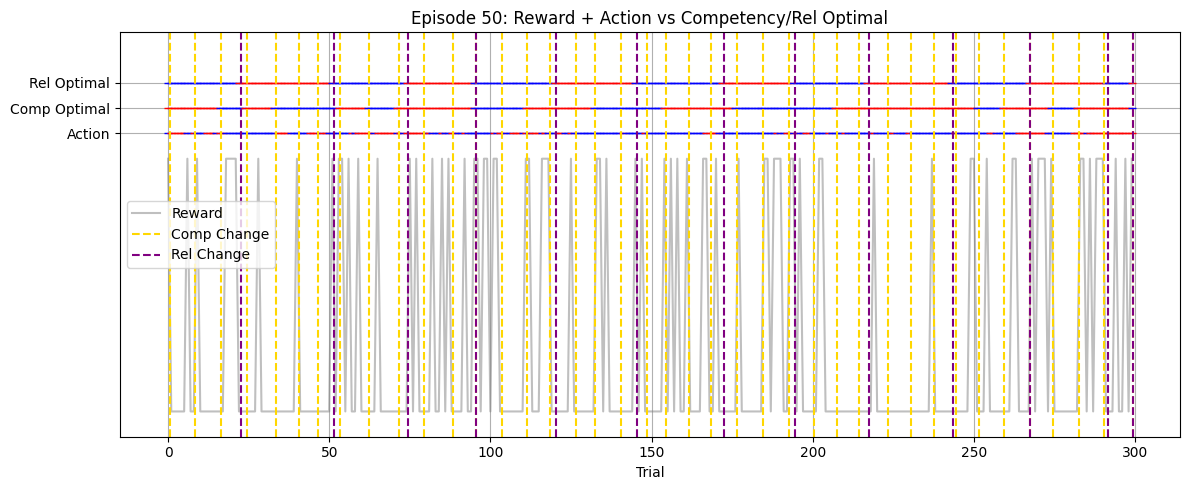

[Episode 50] Action matches Rel Optimal: 139/300 = 46.33%
[Episode 50] Action matches Comp Optimal: 152/300 = 50.67%


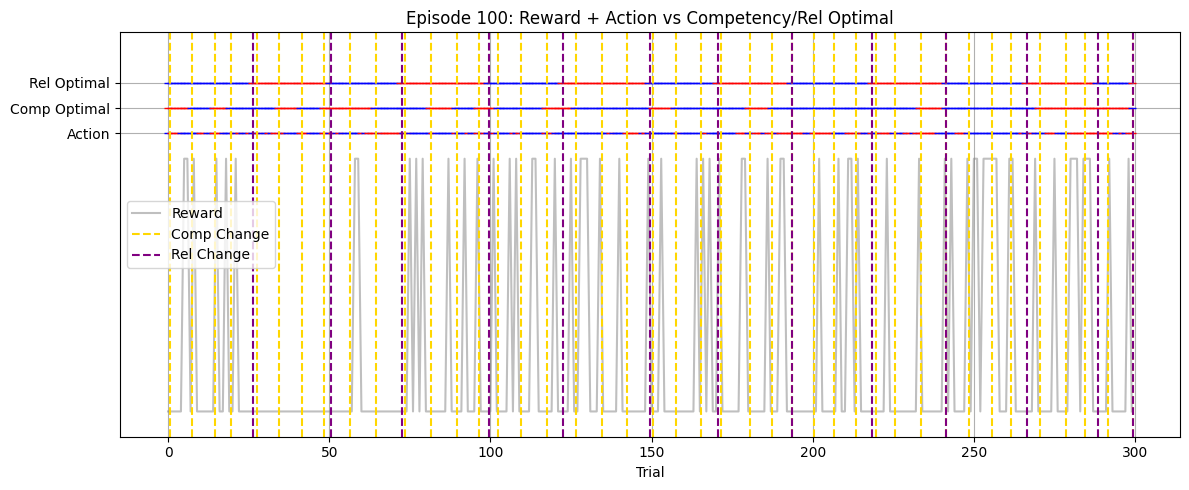

[Episode 100] Action matches Rel Optimal: 159/300 = 53.00%
[Episode 100] Action matches Comp Optimal: 169/300 = 56.33%


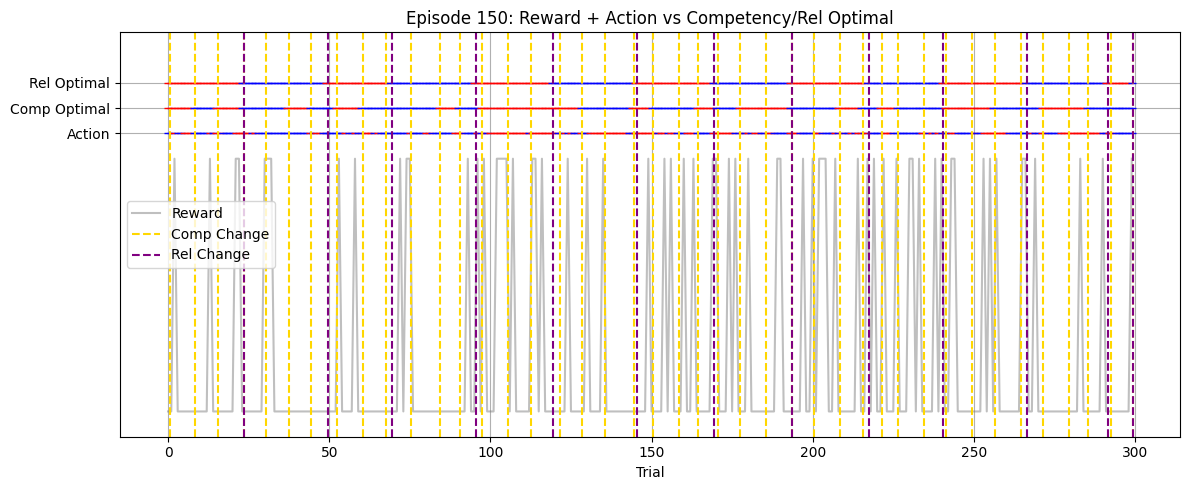

[Episode 150] Action matches Rel Optimal: 156/300 = 52.00%
[Episode 150] Action matches Comp Optimal: 160/300 = 53.33%


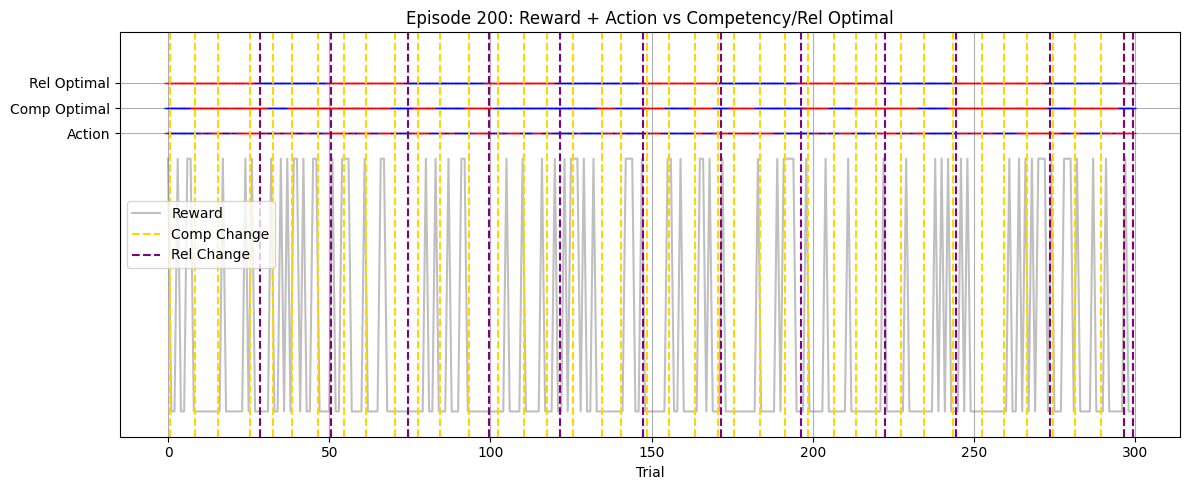

[Episode 200] Action matches Rel Optimal: 151/300 = 50.33%
[Episode 200] Action matches Comp Optimal: 180/300 = 60.00%


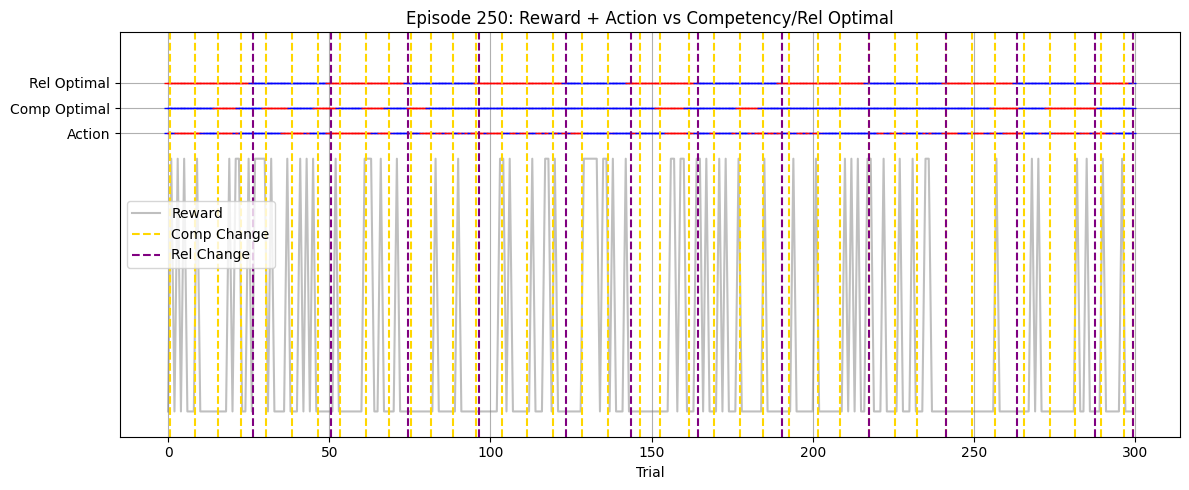

[Episode 250] Action matches Rel Optimal: 169/300 = 56.33%
[Episode 250] Action matches Comp Optimal: 172/300 = 57.33%


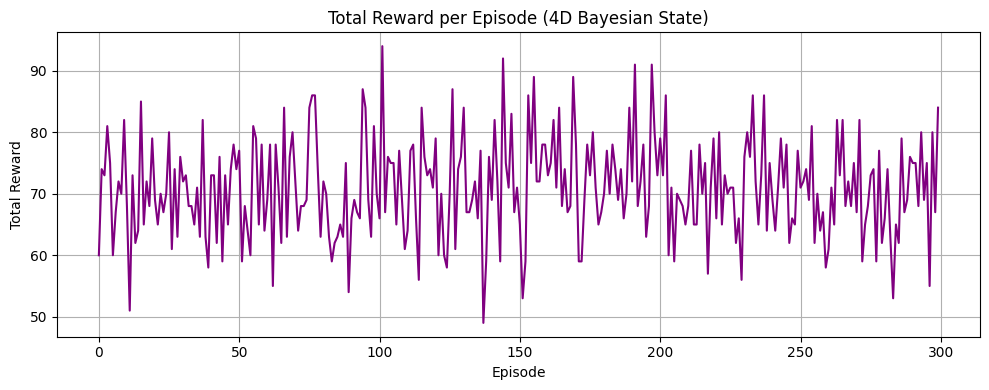

In [ ]:
Q, avg_rewards, episode_plots = train_agent(get_state_fn=joint_bayesian_state_4d, Q=Q4d)

# 시각화
for ep, (df, comp_changes, rel_changes, actions, rewards) in episode_plots.items():
    visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep)

plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='purple')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (4D Bayesian State)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import matplotlib.pyplot as plt

def visualize_episode_with_posteriors(df, comp_changes, rel_changes, actions, rewards, posteriors_comp, posteriors_rel, episode_num):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    trials = list(range(len(actions)))

    # Plot rewards
    ax1.plot(trials, rewards, label='Reward (0/1)', color='black', marker='o', linestyle='-')
    ax1.set_ylabel('Reward')
    ax1.set_xlabel('Trial')
    ax1.set_title(f"Episode {episode_num} - Reward & Posteriors")
    ax1.grid(True)

    # competency posterior
    ax2 = ax1.twinx()
    p1c = [p[0] for p in posteriors_comp]
    p2c = [p[1] for p in posteriors_comp]
    ax2.plot(trials, p1c, color='blue', linestyle='--', label='P(H1_comp)')
    ax2.plot(trials, p2c, color='blue', linestyle=':', label='P(H2_comp)')

    # reliability posterior
    p1r = [p[0] for p in posteriors_rel]
    p2r = [p[1] for p in posteriors_rel]
    ax2.plot(trials, p1r, color='green', linestyle='--', label='P(H1_rel)')
    ax2.plot(trials, p2r, color='green', linestyle=':', label='P(H2_rel)')
    ax2.set_ylabel('Posterior Probabilities')

    # Add vertical lines for change points
    for cp in comp_changes:
        ax1.axvline(cp, color='blue', alpha=0.3, linestyle='--')
    for rp in rel_changes:
        ax1.axvline(rp, color='green', alpha=0.3, linestyle=':')

    fig.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# 수정된 train_agent_posterior 함수: posterior 기록 포함
def train_agent_posterior(get_state_fn, Q, n_episodes=200, epsilon=0.1, alpha=0.1, gamma=0.95):
    n_actions = Q.shape[-1]
    avg_rewards = []
    episode_plots = {}
    posterior_records_comp = {}
    posterior_records_rel = {}

    for ep in range(n_episodes):
        if ep % 50 == 0:
            print(f"Training Episode {ep}")
        df, comp_changes, rel_changes = generate_trials(300)
        env = EelEnv(df, get_state_fn=get_state_fn)
        env.comp_change_points = comp_changes
        env.rel_change_points = rel_changes

        state = get_state_fn(env)
        done = False
        ep_reward = 0

        actions = []
        rewards = []
        comp_points = []
        rel_points = []
        trial_data = []
        posterior_per_trial_comp = []
        posterior_per_trial_rel = []

        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(Q[state])

            next_state_raw, reward, done, info = env.step(action)
            next_state = get_state_fn(env)

            # posterior 저장
            p_h1_comp, p_h2_comp = env.compute_competency_posteriors()
            p_h1_rel, p_h2_rel = env.compute_reliability_posteriors()
            posterior_per_trial_comp.append((p_h1_comp, p_h2_comp))
            posterior_per_trial_rel.append((p_h1_rel, p_h2_rel))

            if not done:
                next_action = np.argmax(Q[next_state])
                target = reward + gamma * Q[next_state + (next_action,)]
            else:
                target = reward

            Q[state + (action,)] += alpha * (target - Q[state + (action,)])
            state = next_state
            ep_reward += reward

            actions.append(action)
            rewards.append(reward)
            trial_data.append(env.trials.iloc[env.current_trial - 1])
            if env.current_trial - 1 in env.comp_change_points:
                comp_points.append(env.current_trial - 1)
            if env.current_trial - 1 in env.rel_change_points:
                rel_points.append(env.current_trial - 1)

        avg_rewards.append(ep_reward)
        df = pd.DataFrame(trial_data)

        if ep % 50 == 0:
            episode_plots[ep] = (df, comp_points, rel_points, actions, rewards)
            posterior_records_comp[ep] = posterior_per_trial_comp
            posterior_records_rel[ep] = posterior_per_trial_rel

    return Q, avg_rewards, episode_plots, posterior_records_comp, posterior_records_rel
'''
Q, avg_rewards, episode_plots, posterior_records_comp, posterior_records_rel = train_agent_posterior(
    get_state_fn=joint_bayesian_state_4d,
    Q=Q4d
)

# 시각화
for ep in episode_plots:
    df, comp_changes, rel_changes, actions, rewards = episode_plots[ep]
    visualize_episode_with_posteriors(
        df, comp_changes, rel_changes, actions, rewards,
        posterior_records_comp[ep], posterior_records_rel[ep],
        episode_num=ep
    )
'''

'\nQ, avg_rewards, episode_plots, posterior_records_comp, posterior_records_rel = train_agent_posterior(\n    get_state_fn=joint_bayesian_state_4d,\n    Q=Q4d\n)\n\n# 시각화\nfor ep in episode_plots:\n    df, comp_changes, rel_changes, actions, rewards = episode_plots[ep]\n    visualize_episode_with_posteriors(\n        df, comp_changes, rel_changes, actions, rewards,\n        posterior_records_comp[ep], posterior_records_rel[ep],\n        episode_num=ep\n    )\n'

In [ ]:
print(episode_plots)

{0: (     left_competency  right_competency  left_reliability  right_reliability
0               0.33               0.8              0.10               0.25
1               0.33               0.8              0.10               0.25
2               0.33               0.8              0.10               0.25
3               0.33               0.8              0.10               0.25
4               0.33               0.8              0.10               0.25
..               ...               ...               ...                ...
295             0.33               0.8              0.10               0.25
296             0.33               0.8              0.10               0.25
297             0.33               0.8              0.10               0.25
298             0.33               0.8              0.10               0.25
299             0.33               0.8              0.25               0.10

[300 rows x 4 columns], [0, 8, 15, 22, 31, 40, 50, 60, 69, 76, 83, 90, 97, 105, 11

In [ ]:
print(posterior_records_comp)

{0: [(np.float64(0.21927551961015151), np.float64(0.7807244803898484)), (np.float64(0.00012533054348411909), np.float64(0.9998746694565158)), (np.float64(3.520370874077126e-05), np.float64(0.9999647962912593)), (np.float64(1.0934481191922905e-07), np.float64(0.999999890655188)), (np.float64(3.071076024626676e-08), np.float64(0.9999999692892397)), (np.float64(9.538610211448687e-11), np.float64(0.999999999904614)), (np.float64(2.679029239064166e-11), np.float64(0.9999999999732098)), (np.float64(2.6790292390641653e-11), np.float64(0.9999999999732098)), (np.float64(0.0001344872248919232), np.float64(0.9998655127751082)), (np.float64(0.0017022166997290834), np.float64(0.9982977833002709)), (np.float64(0.9126674007729071), np.float64(0.08733259922709288)), (np.float64(0.9925082602812487), np.float64(0.0074917397187512155)), (np.float64(0.9995539071870319), np.float64(0.00044609281296821855)), (np.float64(0.9999647962912591), np.float64(3.520370874077125e-05)), (np.float64(0.9999972229275812)

In [ ]:
print(posterior_records_rel)

{0: [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0),

In [17]:
import matplotlib.pyplot as plt

def visualize_posteriors_separately(df, comp_changes, rel_changes,
                                     actions, rewards,
                                     posterior_comp, posterior_rel,
                                     episode_num):
    trials = list(range(len(actions)))

    # 정답 레이블 추출
    comp_labels = [0 if row['left_competency'] > row['right_competency'] else 1 for _, row in df.iterrows()]
    rel_labels  = [0 if row['left_reliability'] > row['right_reliability'] else 1 for _, row in df.iterrows()]

    # Posterior 분리
    p1c = [p[0] for p in posterior_comp]
    p2c = [p[1] for p in posterior_comp]
    p1r = [p[0] for p in posterior_rel]
    p2r = [p[1] for p in posterior_rel]

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # -------- Competency Posterior Plot --------
    ax = axs[0]
    for i, label in enumerate(comp_labels):
        color = 'lightblue' if label == 0 else 'mistyrose'
        ax.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.3)

    ax.plot(trials, p1c, linestyle='--', color='blue', label='P(H1_comp)')
    ax.plot(trials, p2c, linestyle='--',  color='red', label='P(H2_comp)')
    ax.set_ylabel('Competency Posterior')
    ax.set_title(f"Episode {episode_num} - Competency Posterior")

    for cp in comp_changes:
        ax.axvline(cp, color='blue', linestyle='--', alpha=0.3)

    ax.legend()
    ax.grid(True)

    # -------- Reliability Posterior Plot --------
    ax = axs[1]
    for i, label in enumerate(rel_labels):
        color = 'lightgreen' if label == 0 else 'moccasin'
        ax.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.3)

    ax.plot(trials, p1r, linestyle='--', color='green', label='P(H1_rel)')
    ax.plot(trials, p2r, linestyle='--',  color='brown', label='P(H2_rel)')
    ax.set_ylabel('Reliability Posterior')
    ax.set_title(f"Episode {episode_num} - Reliability Posterior")
    ax.set_xlabel('Trial')

    for rp in rel_changes:
        ax.axvline(rp, color='green', linestyle=':', alpha=0.3)

    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


# Comparison between two env likelihood function (Reliability)

1. 기존 베이지안 env

Training Episode 0
Training Episode 50
Training Episode 100
Training Episode 150


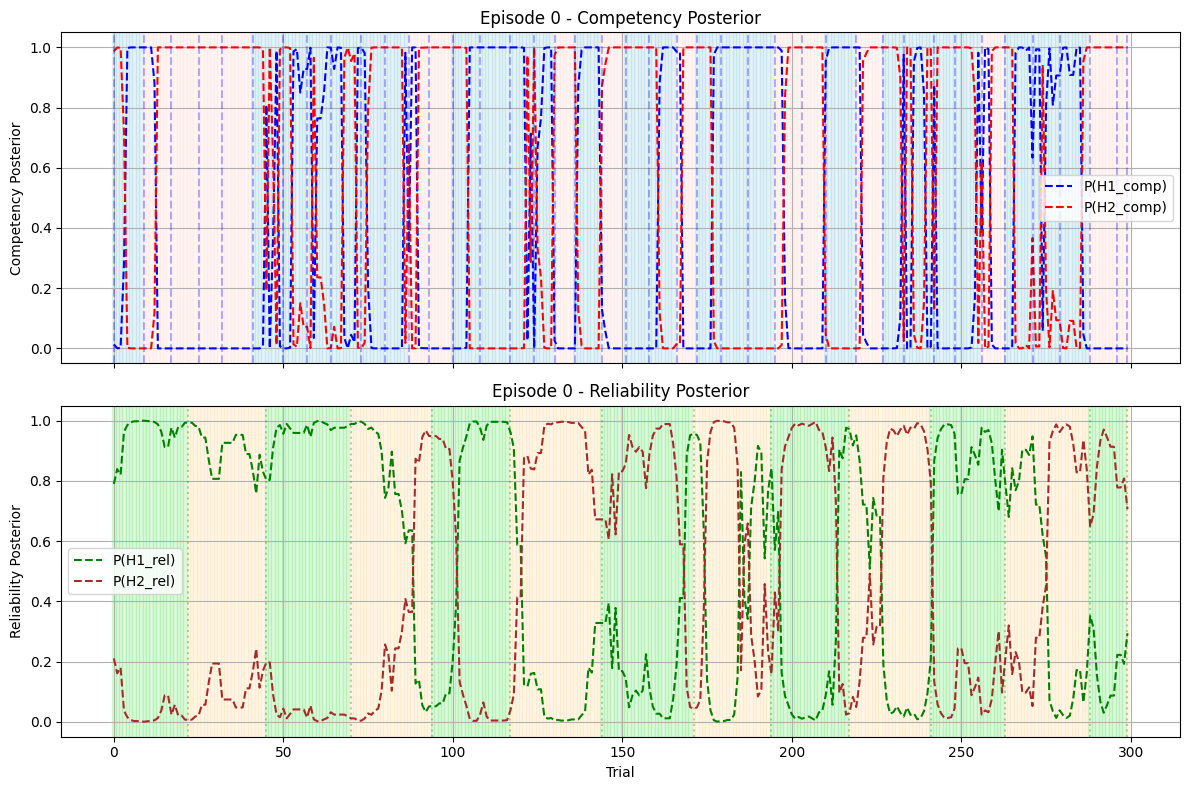

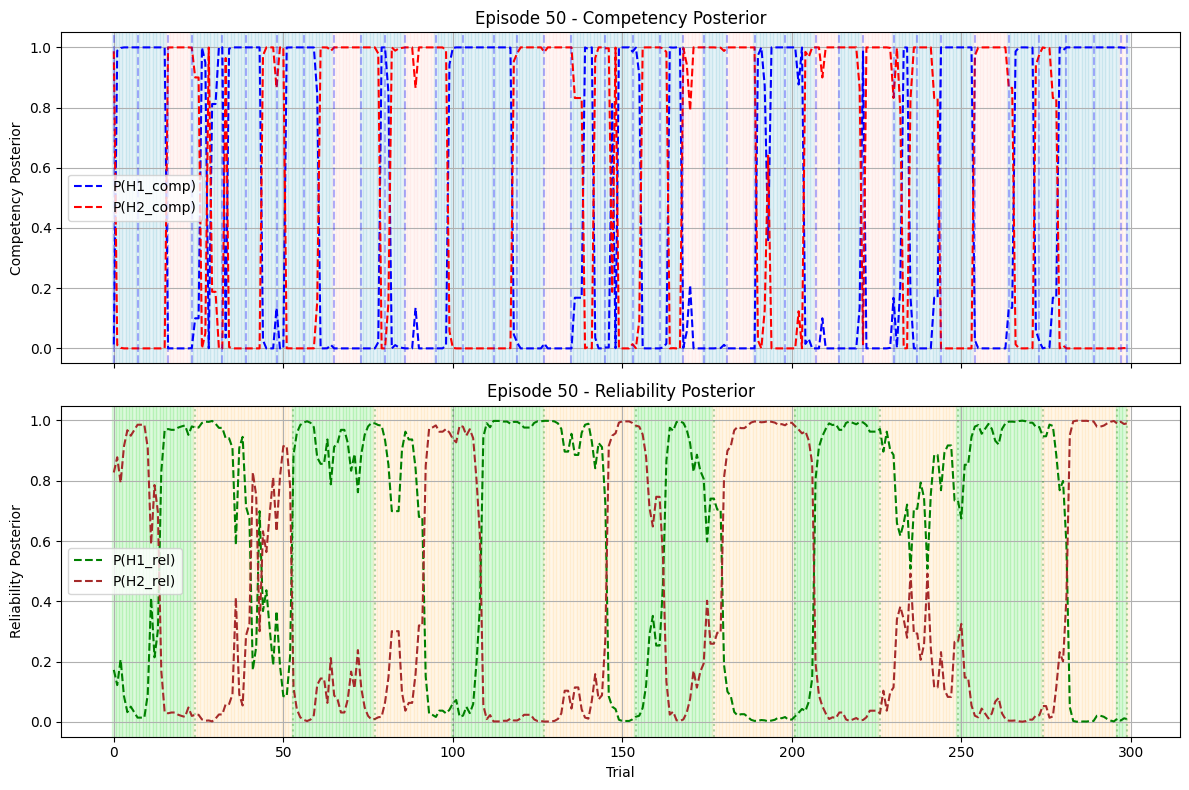

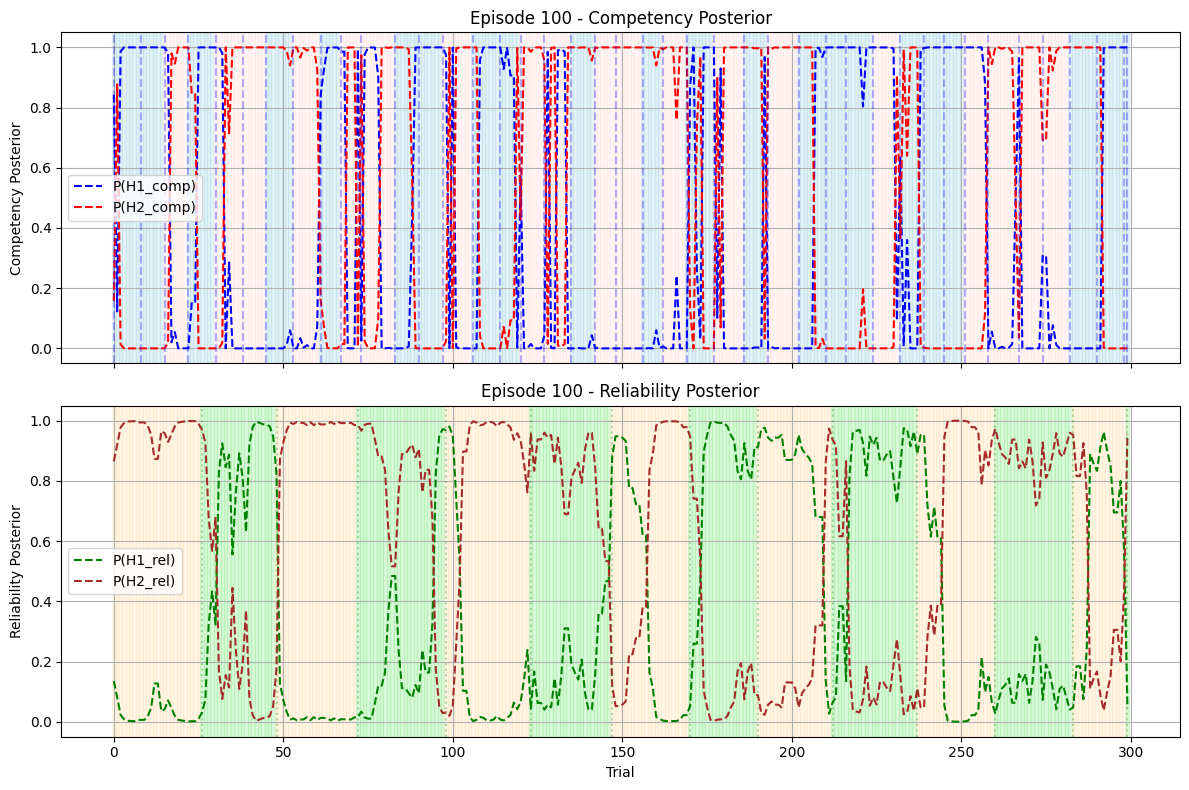

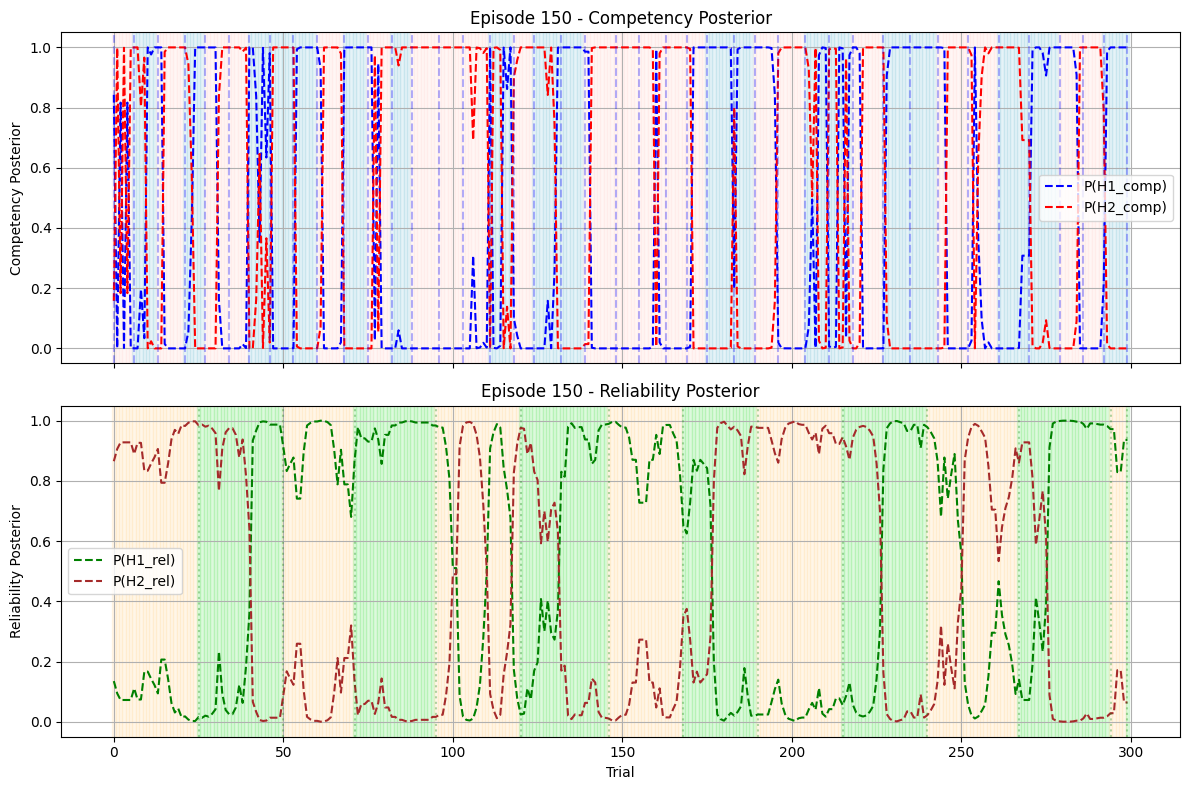

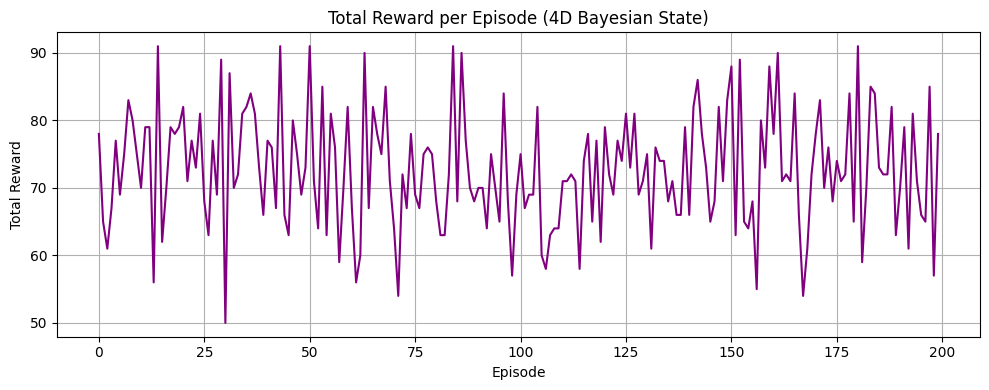

In [20]:

Q, avg_rewards, episode_plots, posterior_records_comp, posterior_records_rel = train_agent_posterior(
    get_state_fn=joint_bayesian_state_4d,
    Q=Q4d
)

# 시각화
for ep in episode_plots:
    df, comp_changes, rel_changes, actions, rewards = episode_plots[ep]
    visualize_posteriors_separately(
        df, comp_changes, rel_changes, actions, rewards,
        posterior_records_comp[ep], posterior_records_rel[ep],
        episode_num=ep
    )



plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='purple')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (4D Bayesian State)")
plt.grid(True)
plt.tight_layout()
plt.show()

2. GPT가 추천해준 ENV

Training Episode 0
Training Episode 50
Training Episode 100
Training Episode 150


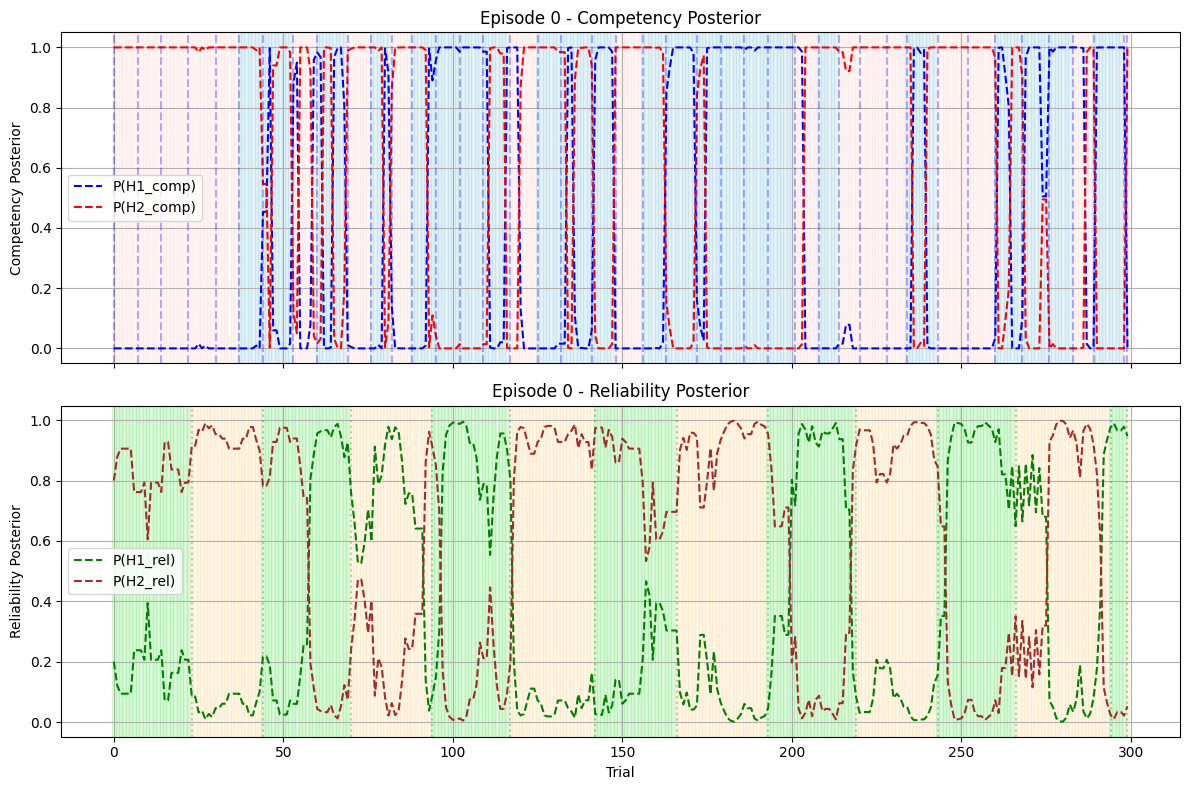

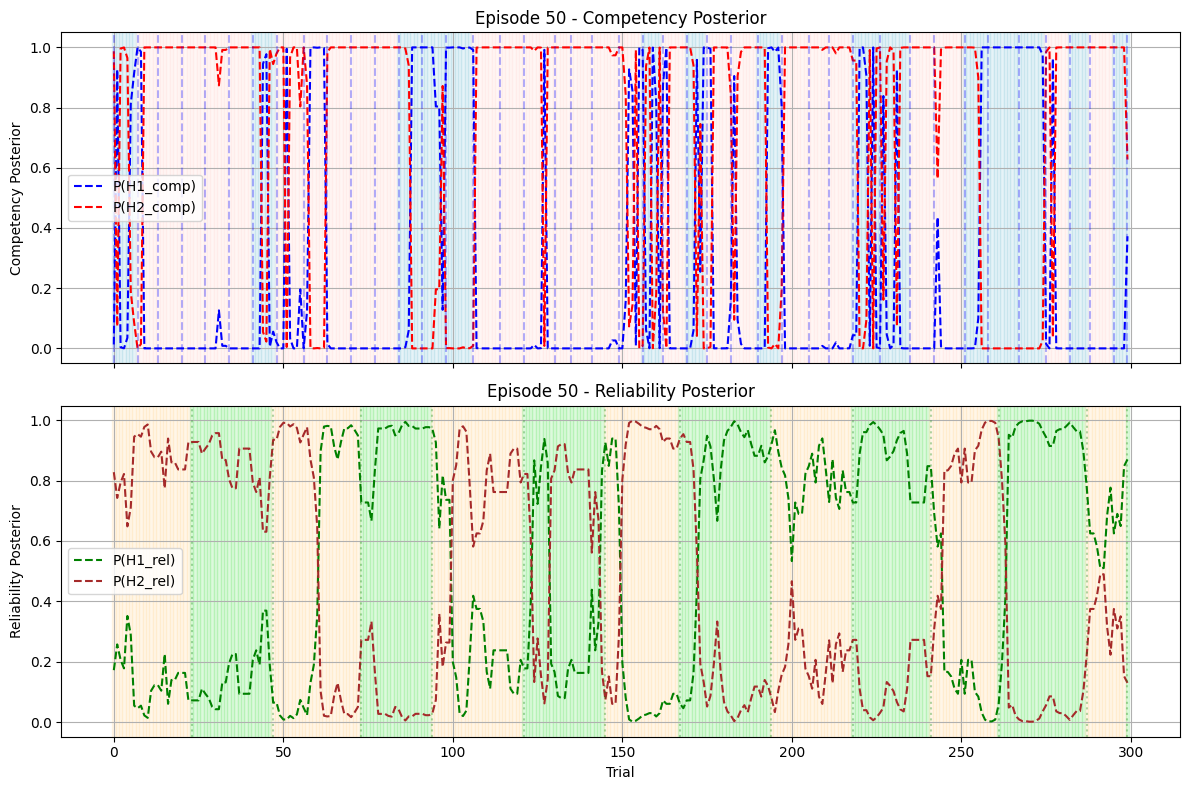

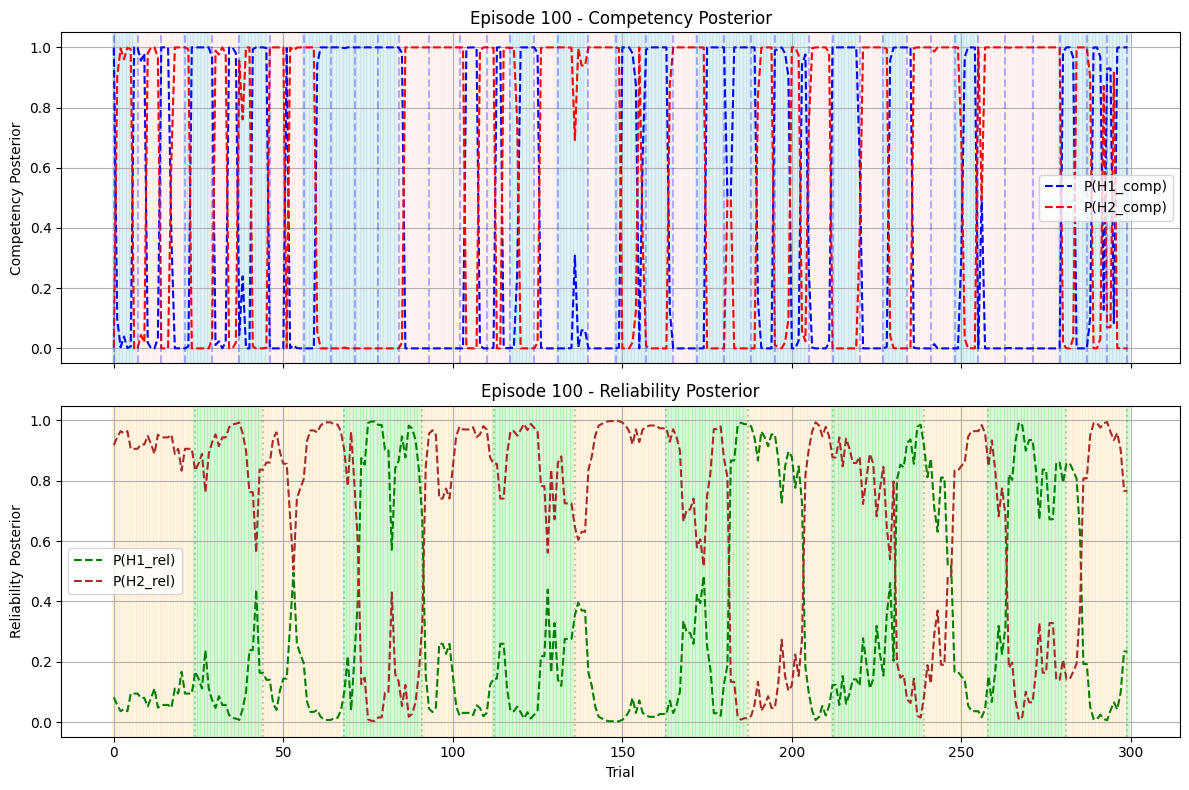

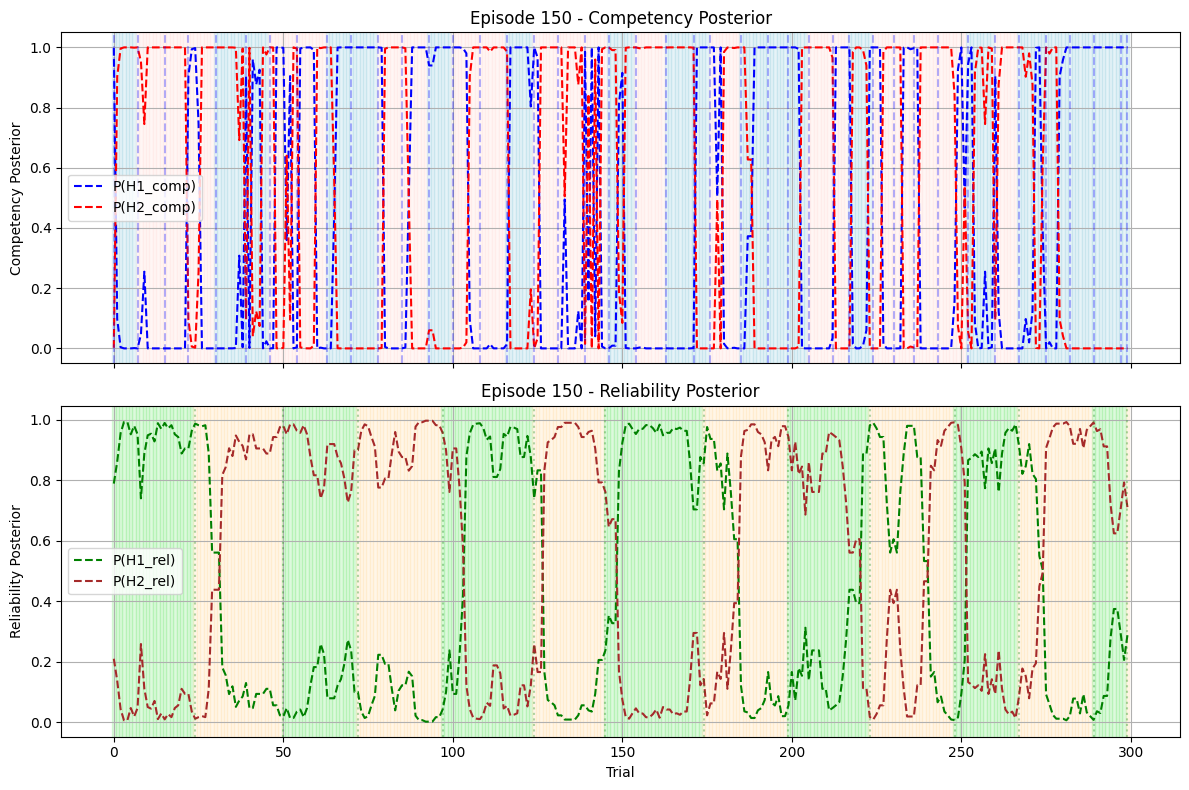

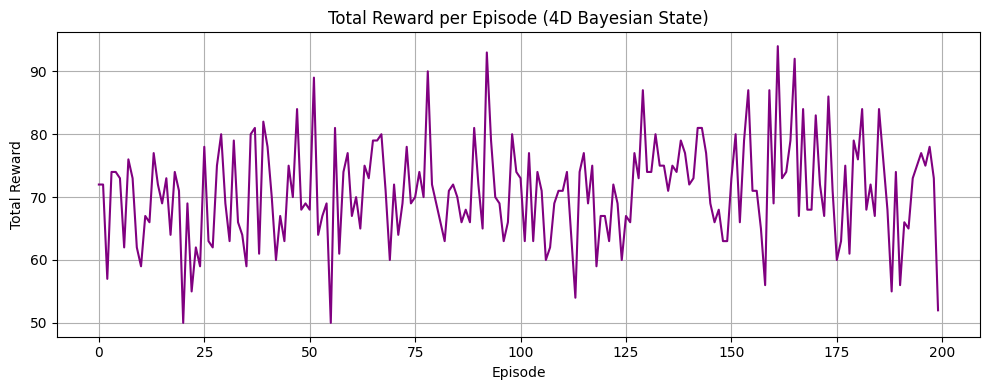

In [22]:
Q, avg_rewards, episode_plots, posterior_records_comp, posterior_records_rel = train_agent_posterior(
    get_state_fn=joint_bayesian_state_4d,
    Q=Q4d
)

# 시각화
for ep in episode_plots:
    df, comp_changes, rel_changes, actions, rewards = episode_plots[ep]
    visualize_posteriors_separately(
        df, comp_changes, rel_changes, actions, rewards,
        posterior_records_comp[ep], posterior_records_rel[ep],
        episode_num=ep
    )



plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='purple')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (4D Bayesian State)")
plt.grid(True)
plt.tight_layout()
plt.show()

Training Episode 0
Training Episode 50
Training Episode 100
Training Episode 150


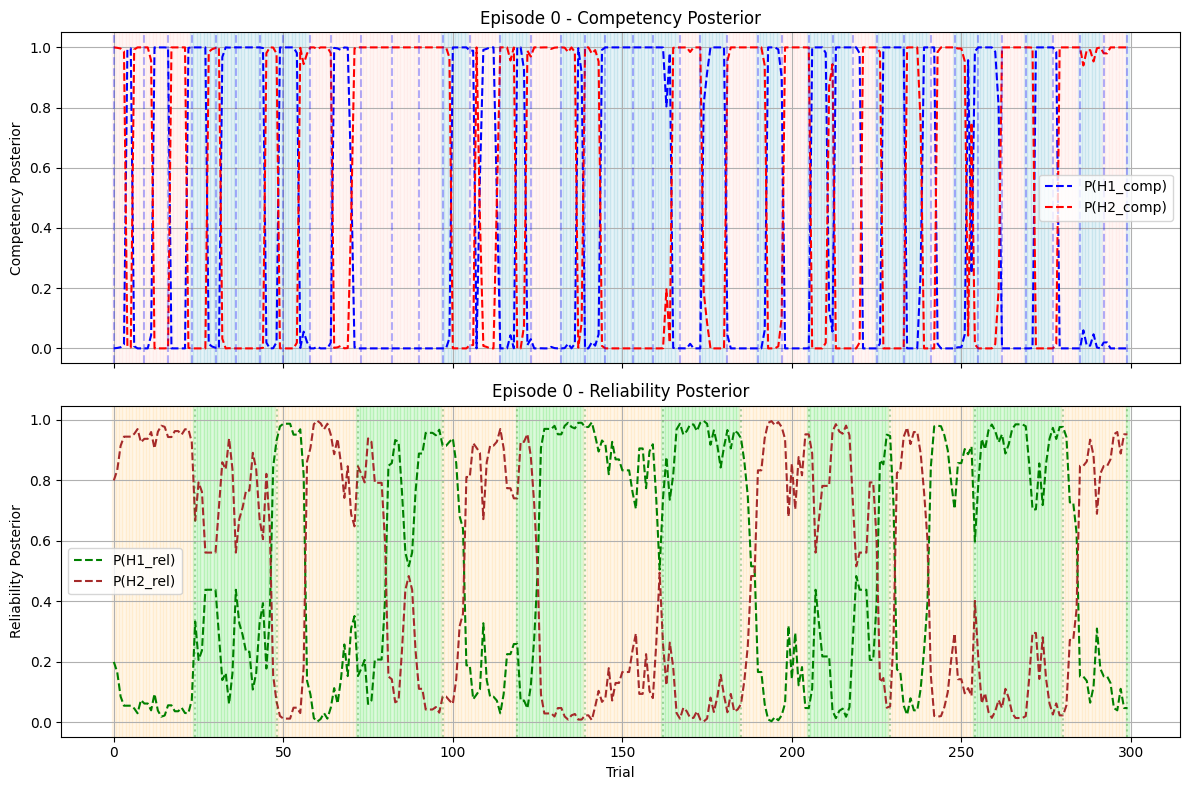

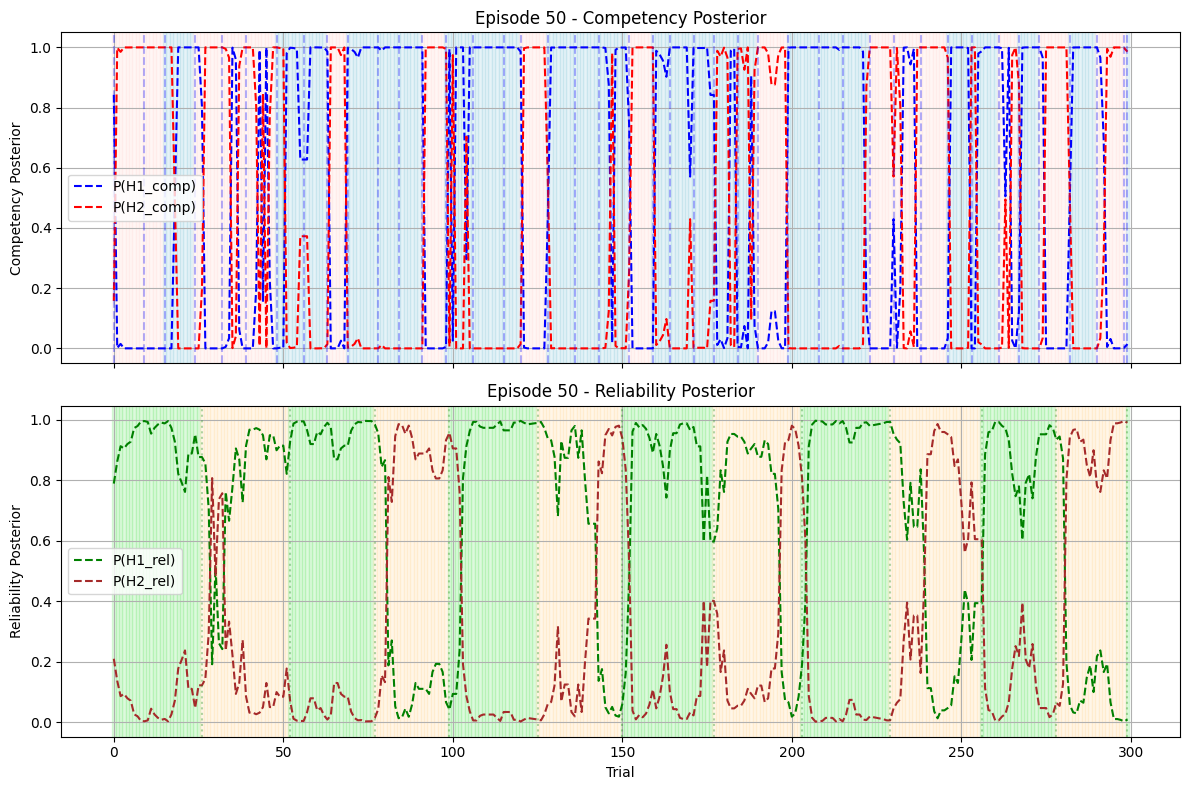

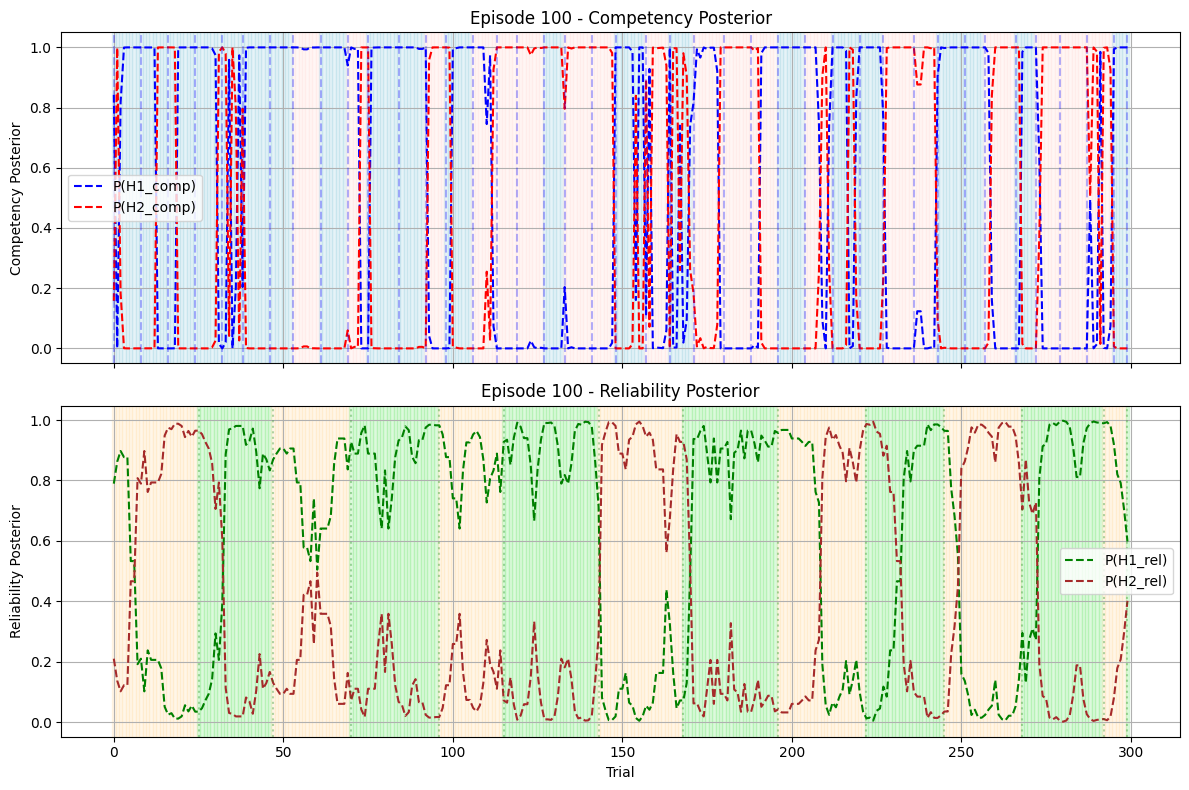

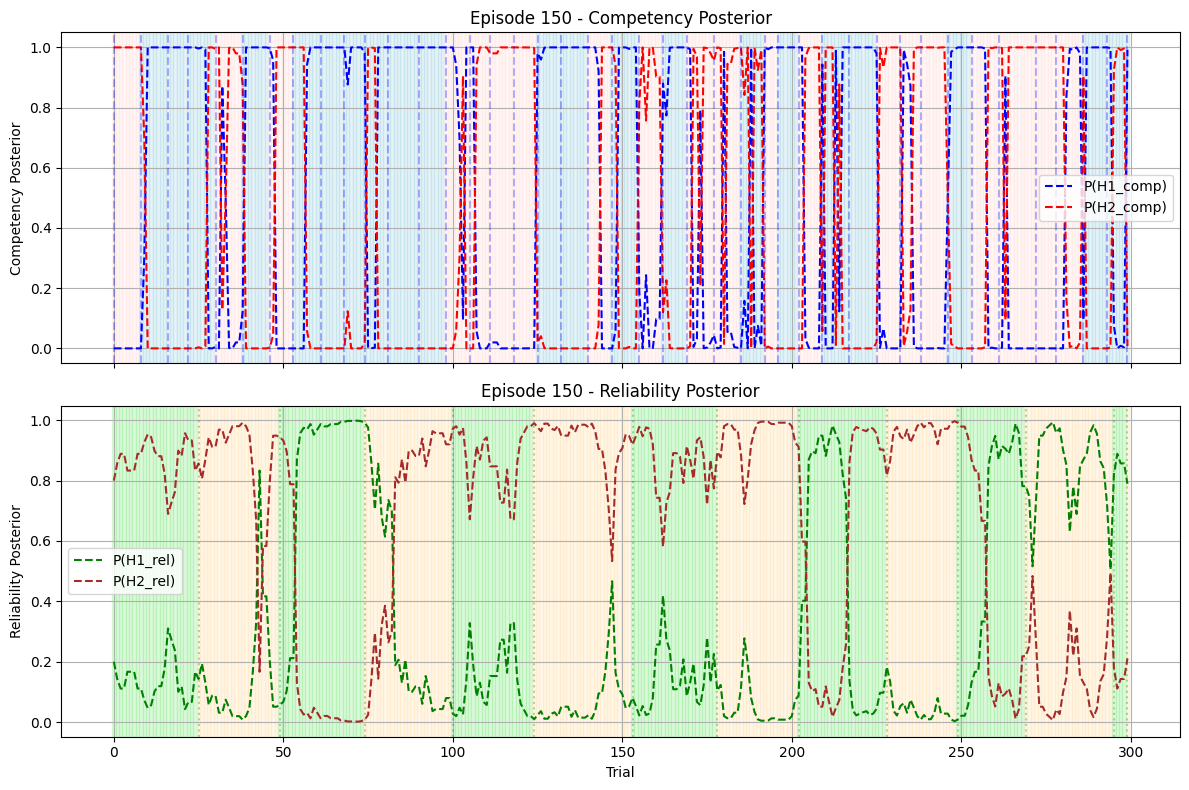

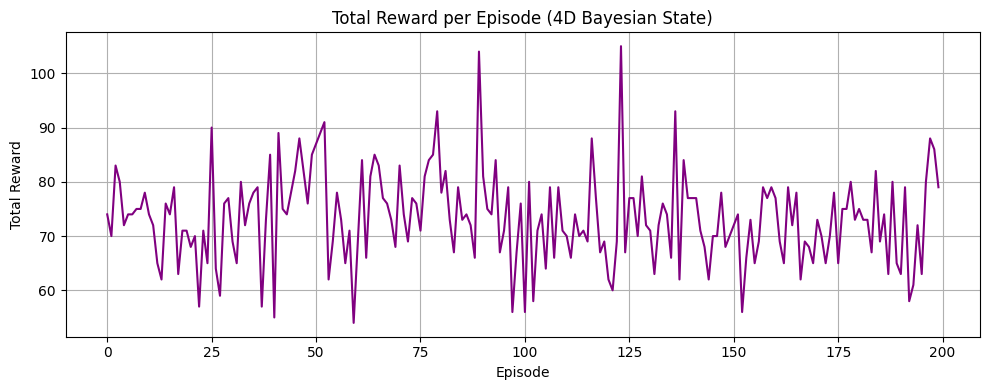

In [25]:
# epsilon 0.2 ver

Q, avg_rewards, episode_plots, posterior_records_comp, posterior_records_rel = train_agent_posterior(
    get_state_fn=joint_bayesian_state_4d,
    Q=Q4d
)

# 시각화
for ep in episode_plots:
    df, comp_changes, rel_changes, actions, rewards = episode_plots[ep]
    visualize_posteriors_separately(
        df, comp_changes, rel_changes, actions, rewards,
        posterior_records_comp[ep], posterior_records_rel[ep],
        episode_num=ep
    )



plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='purple')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (4D Bayesian State)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 해본다면 해봴거... action 잡기...sarsa로 훈련해보기....